In [1]:
import sys
sys.path.insert(0, "/users/jwindmil/2019_WMI/util")

# Initial imports
import Landau_Potential_Diffusion as Landau
import curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd
import dask.array as da
import matplotlib as mpl

import pickle

In [2]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [3]:
def cm_to_inch(m_cm):
    return m_cm/2.54

In [4]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind 

In [5]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

Plot settings

In [73]:
fz = 10
lw = 1
siz = 3

col1 = np.array([255,126,14])/255
col2 = np.array([43,160,43])/255
col3 = np.array([31,119,179])/255

col_A = ['C0', 'C1', 'C2']

# Potential and LFE 

i) RCE

ii) ERA 5

### RCE

Using the 506x506 simulation for consistency with Dave's work

In [7]:
path_RCE = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/output/'

In [8]:
RCE300 = xr.open_mfdataset(path_RCE+'lfff????????.nc', chunks={'time':100})

/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [9]:
dt = 3600; # Timestep in seconds
tcoor = dt*np.arange(0,RCE300.time.shape[0])

t_range = np.arange(0,np.size(RCE300.time)-2)
dPW_dt = (RCE300.TQV.values[t_range+2,:,:]-RCE300.TQV.values[t_range,:,:])/(2*dt)
dPW_dt = np.concatenate((dPW_dt[0:1,:,:],dPW_dt,np.tile(dPW_dt[-1,:,:],(1,1,1))),axis=0)

bin0=np.percentile(a=RCE300.TQV[-24*7:,:,:],q=50,axis=(0,1,2))

tmp,binm,V = Landau.Landau_energy(RCE300.TQV,dPW_dt,bin0,N_bins=30)

In [123]:
dbin = (binm[1:]-binm[:-1])[0]
binc = binm-0.5*dbin
binc = np.append(binc, binc[-1]+dbin)

In [11]:
Ffinal_RCE,binm_Ffinal_RCE,tmp = Landau.Landau_energy(RCE300.TQV.values,N_bins=30,V_fixed=V,bin_fixed=binm)

In [15]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

Calculate Histogram

In [20]:
CWV_PDF_SPIN,SPINedges = np.histogram(RCE300.TQV[:(24*COALstart),:,:],bins=binc,density=True)
CWV_PDF_COAL,COALedges = np.histogram(RCE300.TQV[(24*COALstart):(24*COARstart),:,:],bins=binc,density=True)
CWV_PDF_COAR,COARedges = np.histogram(RCE300.TQV[(24*ENDstart):,:,:],bins=binc,density=True)

Calculate Contour

In [13]:
dx = 3.3e3
CL = np.zeros((np.size(tcoor),))

perc_thresh_RCE = 88

for it,t in enumerate(tcoor):
    print('it=',it,'           ',end='\r')
    CWV_tmp = RCE300.TQV[it,:,:]
    
    CWV_binary = np.zeros(np.shape(CWV_tmp))
    CWV_binary[CWV_tmp>np.percentile(RCE300.TQV[it,:,:], perc_thresh_RCE)] = 1

    binary_boundary=np.copy(CWV_binary)
    binary_boundary[:,1:-1]=0

    L = dx*(measure.perimeter(CWV_binary,8)- np.sum(binary_boundary))
        
    CL[it] = L

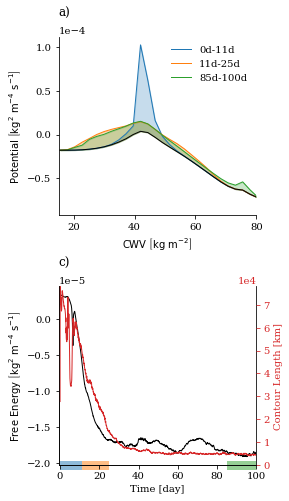

In [122]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(2,1,figsize=(cm_to_inch(9), cm_to_inch(20)))
plt.subplots_adjust(hspace=0.33)

ax[0].set_xlim((15,80))
# ax[0].set_ylim((-1.5e8,1e9))
ax[0].set_title('a)',loc = 'left', pad=20)
ax[0].set_xlabel(r'$\mathrm{CWV}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0].set_ylabel(r'$\mathrm{Potential\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].fill_between((edgTObin(SPINedges)),V,V+CWV_PDF_SPIN*5e-4,color=col_A[0], alpha = 0.25)
ax[0].fill_between((edgTObin(COALedges)),V,V+CWV_PDF_COAL*5e-4,color=col_A[1], alpha = 0.25)
ax[0].fill_between((edgTObin(COARedges)),V,V+CWV_PDF_COAR*5e-4,color=col_A[2], alpha = 0.25)


ax[0].plot((edgTObin(SPINedges)),V+CWV_PDF_SPIN*5e-4,color=col_A[0],label='0d-11d')
ax[0].plot((edgTObin(COALedges)),V+CWV_PDF_COAL*5e-4,color=col_A[1],label='11d-25d')
ax[0].plot((edgTObin(COARedges)),V+CWV_PDF_COAR*5e-4,color=col_A[2],label='85d-100d')
ax[0].legend(frameon=False,loc='upper right')

ax[0].plot(binm,V,color='k')

axbis = ax[1].twinx()
axbis.plot(tcoor/(24*3600),CL/1e3,color='C3')

ymin_C, ymax_C = 0, np.max(CL)/1e3

axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')
axbis.set_ylim((ymin_C, ymax_C))
axbis.set_ylabel('Contour Length [km]',color='C3')


ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(tcoor/(24*3600),Ffinal_RCE,color='k')
ymin_F, ymax_F = ax[1].get_ylim()

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
period_y_max, period_y_min = -0.03, 0.02

ax[1].fill_between(x=tcoor/(24*3600),y1=period_y_min,y2=period_y_max,where=(tcoor/(24*3600)<=11)&(tcoor/(24*3600)>=0),
                   facecolor=col_A[0],alpha=0.5,transform=trans, clip_on=False)
ax[1].fill_between(x=tcoor/(24*3600),y1=period_y_min,y2=period_y_max,where=(tcoor/(24*3600)<=25)&(tcoor/(24*3600)>=11),
                   facecolor=col_A[1],alpha=0.5,transform=trans, clip_on=False)
ax[1].fill_between(x=tcoor/(24*3600),y1=period_y_min,y2=period_y_max,where=(tcoor/(24*3600)<=100)&(tcoor/(24*3600)>=85),
                   facecolor=col_A[2],alpha=0.5,transform=trans, clip_on=False)

ax[1].set_title('c)',loc='left', pad=20)
ax[1].set_xlim((-0.75,100))
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel(r'$\mathrm{Free\ Energy\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)


plt.subplots_adjust(hspace = 0.4)

plt.savefig('./Figures/Fig_2a_c.pdf', bbox_inches = "tight")

### ERA 5

In [18]:
path_ERA = '/project/s916/ERA5_Tom/'

In [68]:
thresh_era5 = 83

Restrict our analysis to a band of the tropical Atlantic

In [21]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18

In [22]:
date1, date2 = np.datetime64('2000-01-01T00:00'), np.datetime64('2017-12-31T23:00')
dt = 3600

In [23]:
PW = xr.open_mfdataset(path_ERA+'????/??PW.nc',combine='by_coords', chunks={'time':100})

In [24]:
PWAtl = PW['tcwv'].sel({'time':slice(date1, date2), 'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = PW.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = PW.latitude.sel({'latitude':slice(latmax,latmin)})

In [25]:
time_A = PWAtl.time.values

In [67]:
CONJUL_data = {}

path_PKL = '/users/jwindmil/2019_WMI/dev/jwindmiller/PKL_DATA/'

for i,year in enumerate(range(2000,2018)):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open(path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, thresh_era5)+str(year)+'.pkl','rb') # open('../jwindmiller/PKL_DATA/10_17_CONTOURL'+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    CONJUL_data[year] = tmp['Tot_Contour_km'][str(year)]
    
cont_t = np.array(get_all_values(CONJUL_data))

#### Calculate Potential and LFE

In [28]:
with open('../jwindmiller/PKL_DATA/pik_times.dat', 'rb') as f:
    times_A = pickle.load(f)
times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

In [30]:
times_Vstart = times_A[0] 
times_Vend   = times_A[1] 

ileftV = find_index(time_A, np.datetime64(times_Vstart))
irightV = find_index(time_A, np.datetime64(times_Vend))

In [31]:
PWAtl_res = PWAtl[ileftV-1:irightV+2,:,:].values # If can't fit in the memory, can't calculate potential

In [32]:
dPW_dt = (PWAtl_res[2:,:,:]-PWAtl_res[:-2,:,:])/(2*dt)

Calculate Potential

In [33]:
tmp,binm_Vfinal,Vfinal = Landau.Landau_energy(PWAtl_res[1:-1,:,:],dPW_dt,N_bins=50)

Calculate LFE

In [34]:
date_startF = times_A[0] 
date_endF   = times_A[-1]

ileftF = find_index(time_A, np.datetime64(date_startF))
irightF = find_index(time_A, np.datetime64(date_endF))
PWAtl_F = PWAtl[ileftF:irightF,:,:]
Ffinal,binm_Ffinal,tmp = Landau.Landau_energy(PWAtl_F.values,N_bins=30,V_fixed=Vfinal,bin_fixed=binm_Vfinal)

Calculate histograms of CWV using bins of Potential

In [36]:
dbin_Vfinal = (binm_Vfinal[1:]-binm_Vfinal[:-1])[0]
binc_Vfinal = binm_Vfinal-0.5*dbin_Vfinal
binc_Vfinal = np.append(binc_Vfinal, binc_Vfinal[-1]+dbin_Vfinal)

In [37]:
dic_hist = {}
times_labels = pd.to_datetime(times_A).strftime("%d-%b")
times_year   = int(pd.to_datetime(times_A[0]).strftime("%Y"))

for i, time in enumerate(times_A):
    tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(6,'h'), time+np.timedelta64(6,'h'))}).values)
    hist, edges = np.histogram(np.ndarray.flatten(tmp), density = True, bins = binc_Vfinal)
    
    dic_hist[times_labels[i]]=hist
    
dic_hist.keys()

dict_keys(['23-Nov', '04-Dec', '07-Dec'])

Plot Potential

2005-11-23T02:00:00.000000000 2005-11-24T02:00:00.000000000
12
2005-12-04T02:00:00.000000000 2005-12-05T02:00:00.000000000
13
2005-12-07T02:00:00.000000000 2005-12-08T02:00:00.000000000
12


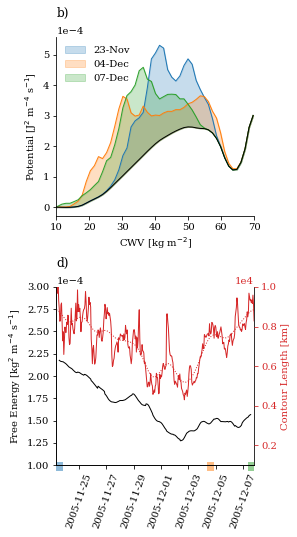

In [124]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

option = 'Agg' # Aggregating, potential averaged from imin_left to imax
option = 'Dis' # Disaggregating, potential averaged from imax to imin_right

fig,ax = plt.subplots(2,1,figsize=(cm_to_inch(9), cm_to_inch(20)))
plt.subplots_adjust(hspace=0.33)


ax[0].set_title('b)',pad=20, loc = 'left')
ax[0].set_xlabel(r'CWV [kg m$^{-2}$]')
ax[0].set_ylabel(r'Potential [J$^{2}$ m$^{-4}$ s$^{-1}$]')
#ax[0].yaxis.tick_right()
#ax[0].yaxis.set_label_position("right")

ax[0].set_xlim(10,70)

for i, time_lab in enumerate(times_labels):
    ax[0].fill_between(binm_Vfinal, Vfinal, Vfinal+dic_hist[time_lab]*5e-3,color=col_A[i],label=time_lab, alpha = 0.25)
    ax[0].plot(binm_Vfinal, Vfinal+dic_hist[time_lab]*5e-3,color=col_A[i])
    
ax[0].plot(binm_Vfinal, Vfinal,color='k')
    
nam = 'Fig2b.pdf'

ax[0].legend(frameon=False)

time_period = time_A[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]
cont_period = cont_t[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]

axbis = ax[1].twinx()
axbis.plot(time_period, cont_period,color='C3')
axbis.plot(time_period, gaussian_filter1d(cont_period, sigma=12), 'C3:')
axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')

axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(PWAtl_F.time, Ffinal,color='k')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70 )


# plt.ylim(100, 300)
# ax1 = plt.gca()
# ax2 = plt.twinx(ax1)
# ax2.plot(time_period, cont_period, 'C1')
# ax2.plot(time_period, gaussian_filter1d(cont_period, sigma=12), 'C1:')
# #plt.xlim(date_startF[i_d], date_endF[i_d])
# plt.ylim(1000, 10000)
# plt.ylabel('Contour length', color = 'C1')

ymin_F, ymax_F = 1.0e-4, 3.0e-4 #ax[1].get_ylim()
ymin_C, ymax_C = 1e3, 1e4 # ax[0].get_ylim()

axbis.set_ylim(ymin_C, ymax_C)

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)

for i, time in enumerate(times_A):

    print(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))
    ax[1].fill_between(x=time_period,y1=period_y_min,y2=period_y_max,where=(time_period<=(time+np.timedelta64(6,'h')))&(time_period>=(time-np.timedelta64(6,'h'))),
                       facecolor=col_A[i],alpha=0.5,transform=trans, clip_on = False)
    
    print(len(np.where(((time_period>=(time-np.timedelta64(6,'h')))&(time_period<=(time+np.timedelta64(6,'h')))))[0]))

ax[1].set_xlim((time_period.min(),time_period.max()))
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_title('d)',loc='left', pad = 20)
ax[1].set_ylabel(r'Free Energy [kg$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

plt.subplots_adjust(hspace = 0.4)

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

plt.savefig('./Figures/Fig_2b_d.pdf', bbox_inches = "tight")